<a href="https://colab.research.google.com/github/sungwoo1004/capstone/blob/main/finding-lane.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


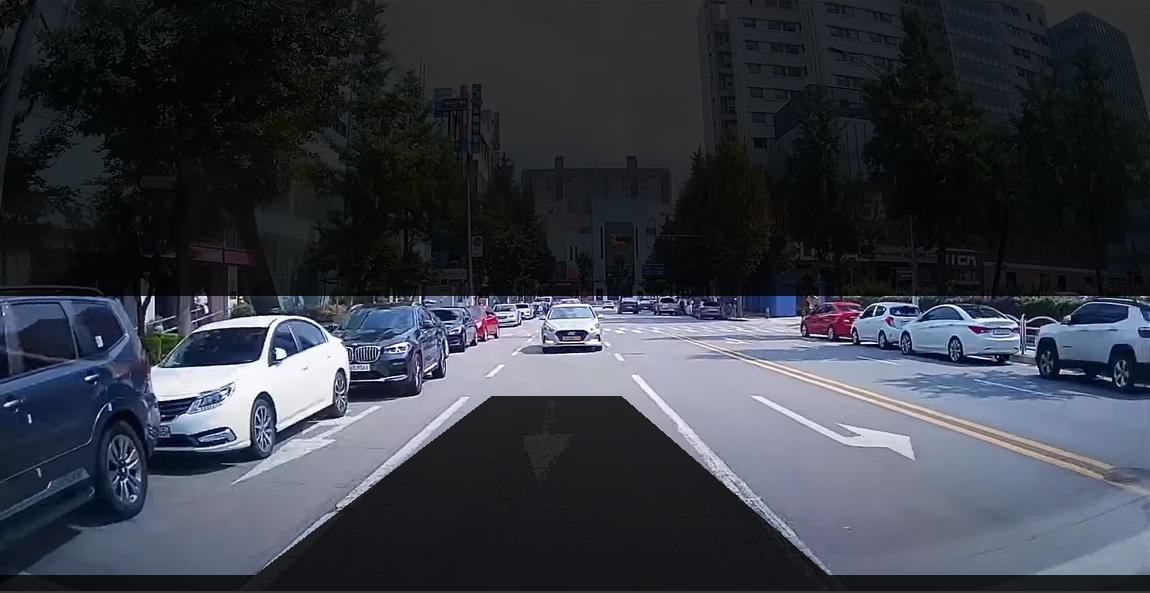

In [ ]:
import pandas as pd
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

def grayscale(img):
  return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def canny(img, low_threshold, high_threshold):
  return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
  return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices, color3=(255, 255, 255), color1=255):

  mask = np.zeros_like(img)

  if len(img.shape) > 2:
    color = color3

  else:
    color = color1


  cv2.fillPoly(mask, vertices, color)

  ROI_image = cv2.bitwise_and(img, mask)
  return ROI_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=4):
  for line in lines:
    for x1, y1, x2, y2 in line:
      cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def draw_fit_line(img, lines, color=[255, 0, 0], thickness=10):
    cv2.line(img, (lines[0], lines[1]), (lines[2], lines[3]), color, thickness)


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
  lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
  #line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.unit8)
  #draw_lines(line_img, lines)

  return lines

def weighted_img(img, initial_img, a=0.8, b=1., c=0.):
  return cv2.addWeighted(initial_img, a, img, b, c)

def get_fitline(img, f_lines):
  lines = np.squeeze(f_lines)
  lines = lines.reshape(lines.shape[0]*2,2)
  rows, cols = img.shape[:2]
  output = cv2.fitLine(lines, cv2.DIST_L2, 0, 0.01, 0.01)
  vx, vy, x, y = output[0], output[1], output[2], output[3]
  x1, y1 = int(((img.shape[0]-1)-y)/vy*vx + x), img.shape[0]-1
  x2, y2 = int(((img.shape[0]/2 + 100)-y)/vy*vx +x), int(img.shape[0]/2 + 100)

  result = [[[x1, y1, x2, y2]]]
  return result




image = cv2.imread('/content/drive/MyDrive/abc/2.jpg')

height, width = image.shape[:2]

gray_img = grayscale(image)

blur_img = gaussian_blur(gray_img, 3)

canny_img = canny(blur_img, 70, 210)

vertices = np.array([[(50, height), (width/2-100, height/2+60), (width/2+100, height/2+60), (width-50, height)]], dtype=np.int32)

ROI_img = region_of_interest(canny_img, vertices)

line_arr = hough_lines(ROI_img, 1, 1 * np.pi/180, 30, 10, 20)
line_arr = np.squeeze(line_arr)

slope_degree = (np.arctan2(line_arr[:,1] - line_arr[:,3], line_arr[:,0] - line_arr[:,2]) * 180) / np.pi

line_arr = line_arr[np.abs(slope_degree) < 160]
slope_degree = slope_degree[np.abs(slope_degree) < 160]

line_arr = line_arr[np.abs(slope_degree) > 95]
slope_degree = slope_degree[np.abs(slope_degree) > 95]

L_lines, R_lines = line_arr[(slope_degree > 0), :], line_arr[(slope_degree < 0), :]
temp = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
L_lines, R_lines = L_lines[:, None], R_lines[:, None]

left_fit_line = get_fitline(image, L_lines)
right_fit_line = get_fitline(image, R_lines)


#################################
################################# def def def def def


pts = [left_fit_line, right_fit_line]
pts = np.array(pts).reshape(1, -1, 2)
#print(pts)

pts = pts.tolist()
pts[0][1], pts[0][2] = pts[0][2], pts[0][1]
pts[0][2], pts[0][3] = pts[0][3], pts[0][2]

pts = np.array(pts).reshape(1, -1, 2)
#print(pts)

cv2.fillPoly(temp, pts, (255, 0, 255), cv2.LINE_AA)


#################################
################################# def def def def def


mask_lane = np.zeros_like(image)
cv2.fillPoly(mask_lane, pts , (255,255,255))

mask_lane_inv = cv2.bitwise_not(mask_lane)

mask_roi = np.zeros_like(image)
mask_roi[int(height/2):int(width/2), :]=255

mask_comb = cv2.bitwise_and(mask_lane_inv, mask_roi)


mask_result = cv2.bitwise_and(mask_comb, image)

dst = cv2.addWeighted(image, 0.2, mask_result, 0.8, 0.0)
cv2_imshow(dst)

#draw_lines(temp, left_fit_line)
#draw_lines(temp, right_fit_line)


#################################
#################################
